In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from msfm.utils import files
from msi.utils import plotting

plt.rcParams.update(
    {
        "font.family": "Arial",
        "font.size": 20,
        "font.style": "normal",
        "font.variant": "normal",
    }
)

# throughput

In [14]:
# throughput
# gpus = 2**np.arange(2, 6)

# 1 node: https://wandb.ai/eth-cosmo/y3-deep-lss/runs/vagjbtuj, "/global/u2/a/athomsen/y3-deep-lss/submissions/pasc/throughput/logs/v7/combined/delta/horovod_23283752.log"
# 2 nodes: https://wandb.ai/eth-cosmo/y3-deep-lss/runs/z1atvhr4, "/global/u2/a/athomsen/y3-deep-lss/submissions/pasc/throughput/logs/v7/combined/delta/horovod_23283768.log"
# 4 nodes: https://wandb.ai/eth-cosmo/y3-deep-lss/runs/za4q3jfw, "/global/u2/a/athomsen/y3-deep-lss/submissions/pasc/throughput/logs/v7/combined/delta/horovod_23283774.log"
# 8 nodes: https://wandb.ai/eth-cosmo/y3-deep-lss/runs/zmfv9qa5, "/global/u2/a/athomsen/y3-deep-lss/submissions/pasc/throughput/logs/v7/combined/delta/horovod_23283783.log"
# 16 nodes: https://wandb.ai/eth-cosmo/y3-deep-lss/runs/zr39h7zn, "/global/u2/a/athomsen/y3-deep-lss/submissions/pasc/throughput/logs/v7/combined/delta/horovod_23441521.log"
# 32 nodes: https://wandb.ai/eth-cosmo/y3-deep-lss/runs/uv8w4qdl
# delta_throughput = [9.69, 19.25, 38.25, 76.23, 150.13]

# 1 node: https://wandb.ai/eth-cosmo/y3-deep-lss/runs/yu61bflm, "/global/u2/a/athomsen/y3-deep-lss/submissions/pasc/throughput/logs/v7/combined/likelihood/horovod_23287167.log"
# 2 nodes: https://wandb.ai/eth-cosmo/y3-deep-lss/runs/qd20thku, "/global/u2/a/athomsen/y3-deep-lss/submissions/pasc/throughput/logs/v7/combined/likelihood/horovod_23287169.log"
# 4 nodes: https://wandb.ai/eth-cosmo/y3-deep-lss/runs/z6772xwx, "/global/u2/a/athomsen/y3-deep-lss/submissions/pasc/throughput/logs/v7/combined/likelihood/horovod_23287173.log"
# 8 nodes: https://wandb.ai/eth-cosmo/y3-deep-lss/runs/wkr7uk9b, "/global/u2/a/athomsen/y3-deep-lss/submissions/pasc/throughput/logs/v7/combined/likelihood/horovod_23287174.log"
# 16 nodes: https://wandb.ai/eth-cosmo/y3-deep-lss/runs/fl2rigtx, "/global/u2/a/athomsen/y3-deep-lss/submissions/pasc/throughput/logs/v7/combined/likelihood/horovod_23441536.log"
# 32 nodes: https://wandb.ai/eth-cosmo/y3-deep-lss/runs/kmkfvyj1
# grid_throughput = [142.09, 271.53, 520.98, 1009.18, 1984.69]

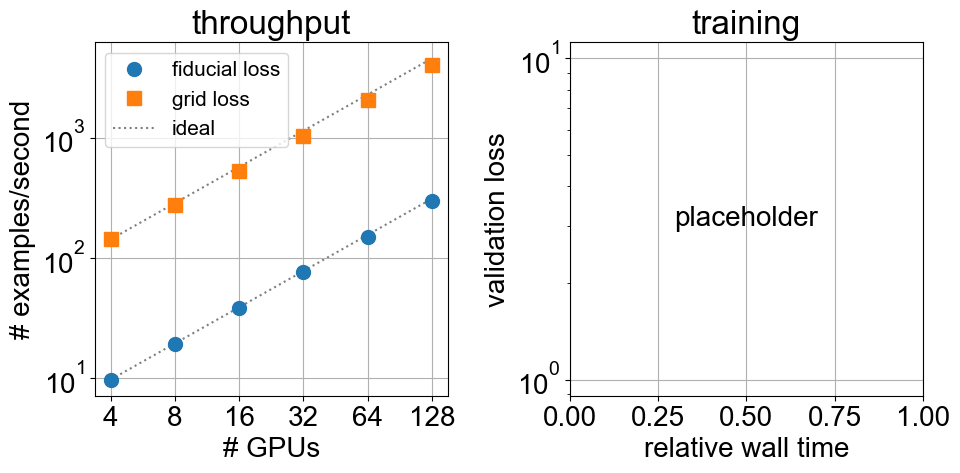

In [24]:
nodes = 2**np.arange(0, 6)
gpus = 4 * nodes
local_batch_size = 120

mu_throughput = []
sigma_throughput = []

for loss in ["delta", "likelihood"]:
    if loss == "delta":
        local_batch_size = 4
    elif loss == "likelihood":
        local_batch_size = 60

    for node, gpu in zip(nodes, gpus):
        csv_file = f"/Users/arne/git/multiprobe-simulation-forward-model/notebooks/plotting/pasc/data/throughput/{node}_node_{loss}.csv"
        step_time = pd.read_csv(csv_file)
        step_time = step_time[step_time["Step"] > 200]
        step_time = step_time.iloc[:, 1]
        time_per_step = 1 / step_time
        
        global_batch_size = local_batch_size * gpu
        
        throughput = global_batch_size * time_per_step

        mu_throughput.append(throughput.mean())
        sigma_throughput.append(throughput.std())


fig, ax = plt.subplots(figsize=(10, 5), sharex=False, sharey=False, ncols=2)

# throughput
ax[0].plot(gpus, mu_throughput[:len(nodes)], label="fiducial loss", marker="o", linestyle="", markersize=10)
ax[0].plot(gpus, mu_throughput[len(nodes):], label="grid loss", marker="s", linestyle="", markersize=10)
# ax[0].errorbar(gpus, mu_throughput[:len(nodes)], yerr=sigma_throughput[:len(nodes)], label="fiducial loss", marker="o", linestyle="", markersize=5, capsize=2, elinewidth=3)
# ax[0].errorbar(gpus, mu_throughput[len(nodes):], yerr=sigma_throughput[len(nodes):], label="grid loss", marker="s", linestyle="", markersize=5, capsize=2, elinewidth=3)

ax[0].plot(gpus, mu_throughput[0]/4*gpus, label="ideal", color="k", alpha=0.5, marker="", linestyle=":", markersize=12, zorder=0)
ax[0].plot(gpus, mu_throughput[len(nodes)]/4*gpus, color="k", alpha=0.5, marker="", linestyle=":", markersize=12, zorder=0)

ax[0].set(title="throughput", xlabel="# GPUs", ylabel="# examples/second", xscale="log", yscale="log")
ax[0].set_xticks(gpus, gpus)
ax[0].minorticks_off()
# ax[0].legend(loc="center", fontsize=12)
ax[0].legend(loc="upper left", fontsize=15)

# training
# ax[1].plot(gpus,10*gpus, label="fiducial loss")
# ax[1].plot(gpus,7*gpus, label="grid loss")

ax[1].set(title="training", xlabel="relative wall time", ylabel="validation loss", xscale="linear", yscale="log")
ax[1].text(0.5, 0.5, "placeholder", horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=20)

# shared cosmetics
for i in range(2):
    ax[i].grid(True)
    ax[i].set_box_aspect(1)

fig.tight_layout()
fig.savefig("./plots/throughput+training.pdf", bbox_inches="tight", dpi=300)

In [16]:
# nodes = 2**np.arange(0, 6)
# gpus = 4 * nodes
# local_batch_size = 120

# mu_throughput = []
# sigma_throughput = []

# for loss in ["delta", "likelihood"]:
#     if loss == "delta":
#         local_batch_size = 4
#     elif loss == "likelihood":
#         local_batch_size = 60

#     for node, gpu in zip(nodes, gpus):
#         csv_file = f"/Users/arne/git/multiprobe-simulation-forward-model/notebooks/plotting/pasc/data/throughput/{node}_node_{loss}.csv"
#         step_time = pd.read_csv(csv_file)
#         step_time = step_time[step_time["Step"] > 200]
#         step_time = step_time.iloc[:, 1]
#         time_per_step = 1 / step_time
        
#         global_batch_size = local_batch_size * gpu
        
#         throughput = global_batch_size * time_per_step

#         mu_throughput.append(throughput.mean())
#         sigma_throughput.append(throughput.std())


# fig, ax = plt.subplots(figsize=(5, 5))

# # throughput
# ax.plot(gpus, mu_throughput[:len(nodes)], label="fiducial loss", marker="o", linestyle="", markersize=10)
# ax.plot(gpus, mu_throughput[len(nodes):], label="grid loss", marker="s", linestyle="", markersize=10)

# ax.plot(gpus, mu_throughput[0]/4*gpus, label="ideal", color="k", alpha=0.5, marker="", linestyle=":", markersize=12, zorder=0)
# ax.plot(gpus, mu_throughput[len(nodes)]/4*gpus, color="k", alpha=0.5, marker="", linestyle=":", markersize=12, zorder=0)

# ax.set(xlabel="# GPUs", ylabel="# examples/second", xscale="log", yscale="log")
# # ax.set(title="throughput", xlabel="# GPUs", ylabel="# examples/second", xscale="linear", yscale="linear")
# ax.set_xticks(gpus, gpus)
# ax.minorticks_off()
# ax.legend(loc="center", fontsize=12)
# ax.grid(True)

# fig.tight_layout()
# fig.savefig("./plots/throughput.png", bbox_inches="tight", dpi=300)

In [17]:
# delta_throughput = [9.69, 19.25, 38.25, 76.23, 150.13]
# grid_throughput = [142.09, 271.53, 520.98, 1009.18, 1984.69]

In [18]:
# fig, ax = plt.subplots(figsize=(10, 5), sharex=False, sharey=False, ncols=2)

# # throughput
# ax[0].plot(gpus, delta_throughput, label="fiducial loss", marker="o", linestyle="", markersize=12)
# ax[0].plot(gpus, grid_throughput, label="grid loss", marker="s", linestyle="", markersize=12)

# ax[0].plot(gpus, delta_throughput[0]/4*gpus, label="ideal", color="k", alpha=0.5, marker="", linestyle=":", markersize=12, zorder=0)
# ax[0].plot(gpus, grid_throughput[0]/4*gpus, color="k", alpha=0.5, marker="", linestyle=":", markersize=12, zorder=0)

# ax[0].set(title="throughput", xlabel="# GPUs", ylabel="# examples/second", xscale="log", yscale="log")
# ax[0].set_xticks(gpus, gpus)
# ax[0].minorticks_off()
# ax[0].legend(loc="center", fontsize=12)

# # training
# # ax[1].plot(gpus,10*gpus, label="fiducial loss")
# # ax[1].plot(gpus,7*gpus, label="grid loss")

# ax[1].set(title="training", xlabel="# steps", ylabel="validation loss", xscale="linear", yscale="log")

# # shared cosmetics
# for i in range(2):
#     ax[i].grid(True)
#     ax[i].set_box_aspect(1)

# fig.tight_layout()
# fig.savefig("./pasc/throughput+training.png", bbox_inches="tight", dpi=300)

# contours

In [19]:
plt.rcParams.update(
    {
        "font.family": "Arial",
        "font.size": 20,
        "font.style": "normal",
        "font.variant": "normal",
    }
)

100%|██████████| 36/36 [00:00<00:00, 2372.46it/s]


24-04-29 15:36:08  plotting.py INF   Saved the plot to ./plots/contours_probe_comparison.pdf 


array([[<Axes: ylabel='$\\Omega_m$'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$\\sigma_8$'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$w_0$'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$A_{IA}$'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$\\eta_{A_{IA}}$'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$b_g$'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='$\\Omega_m$

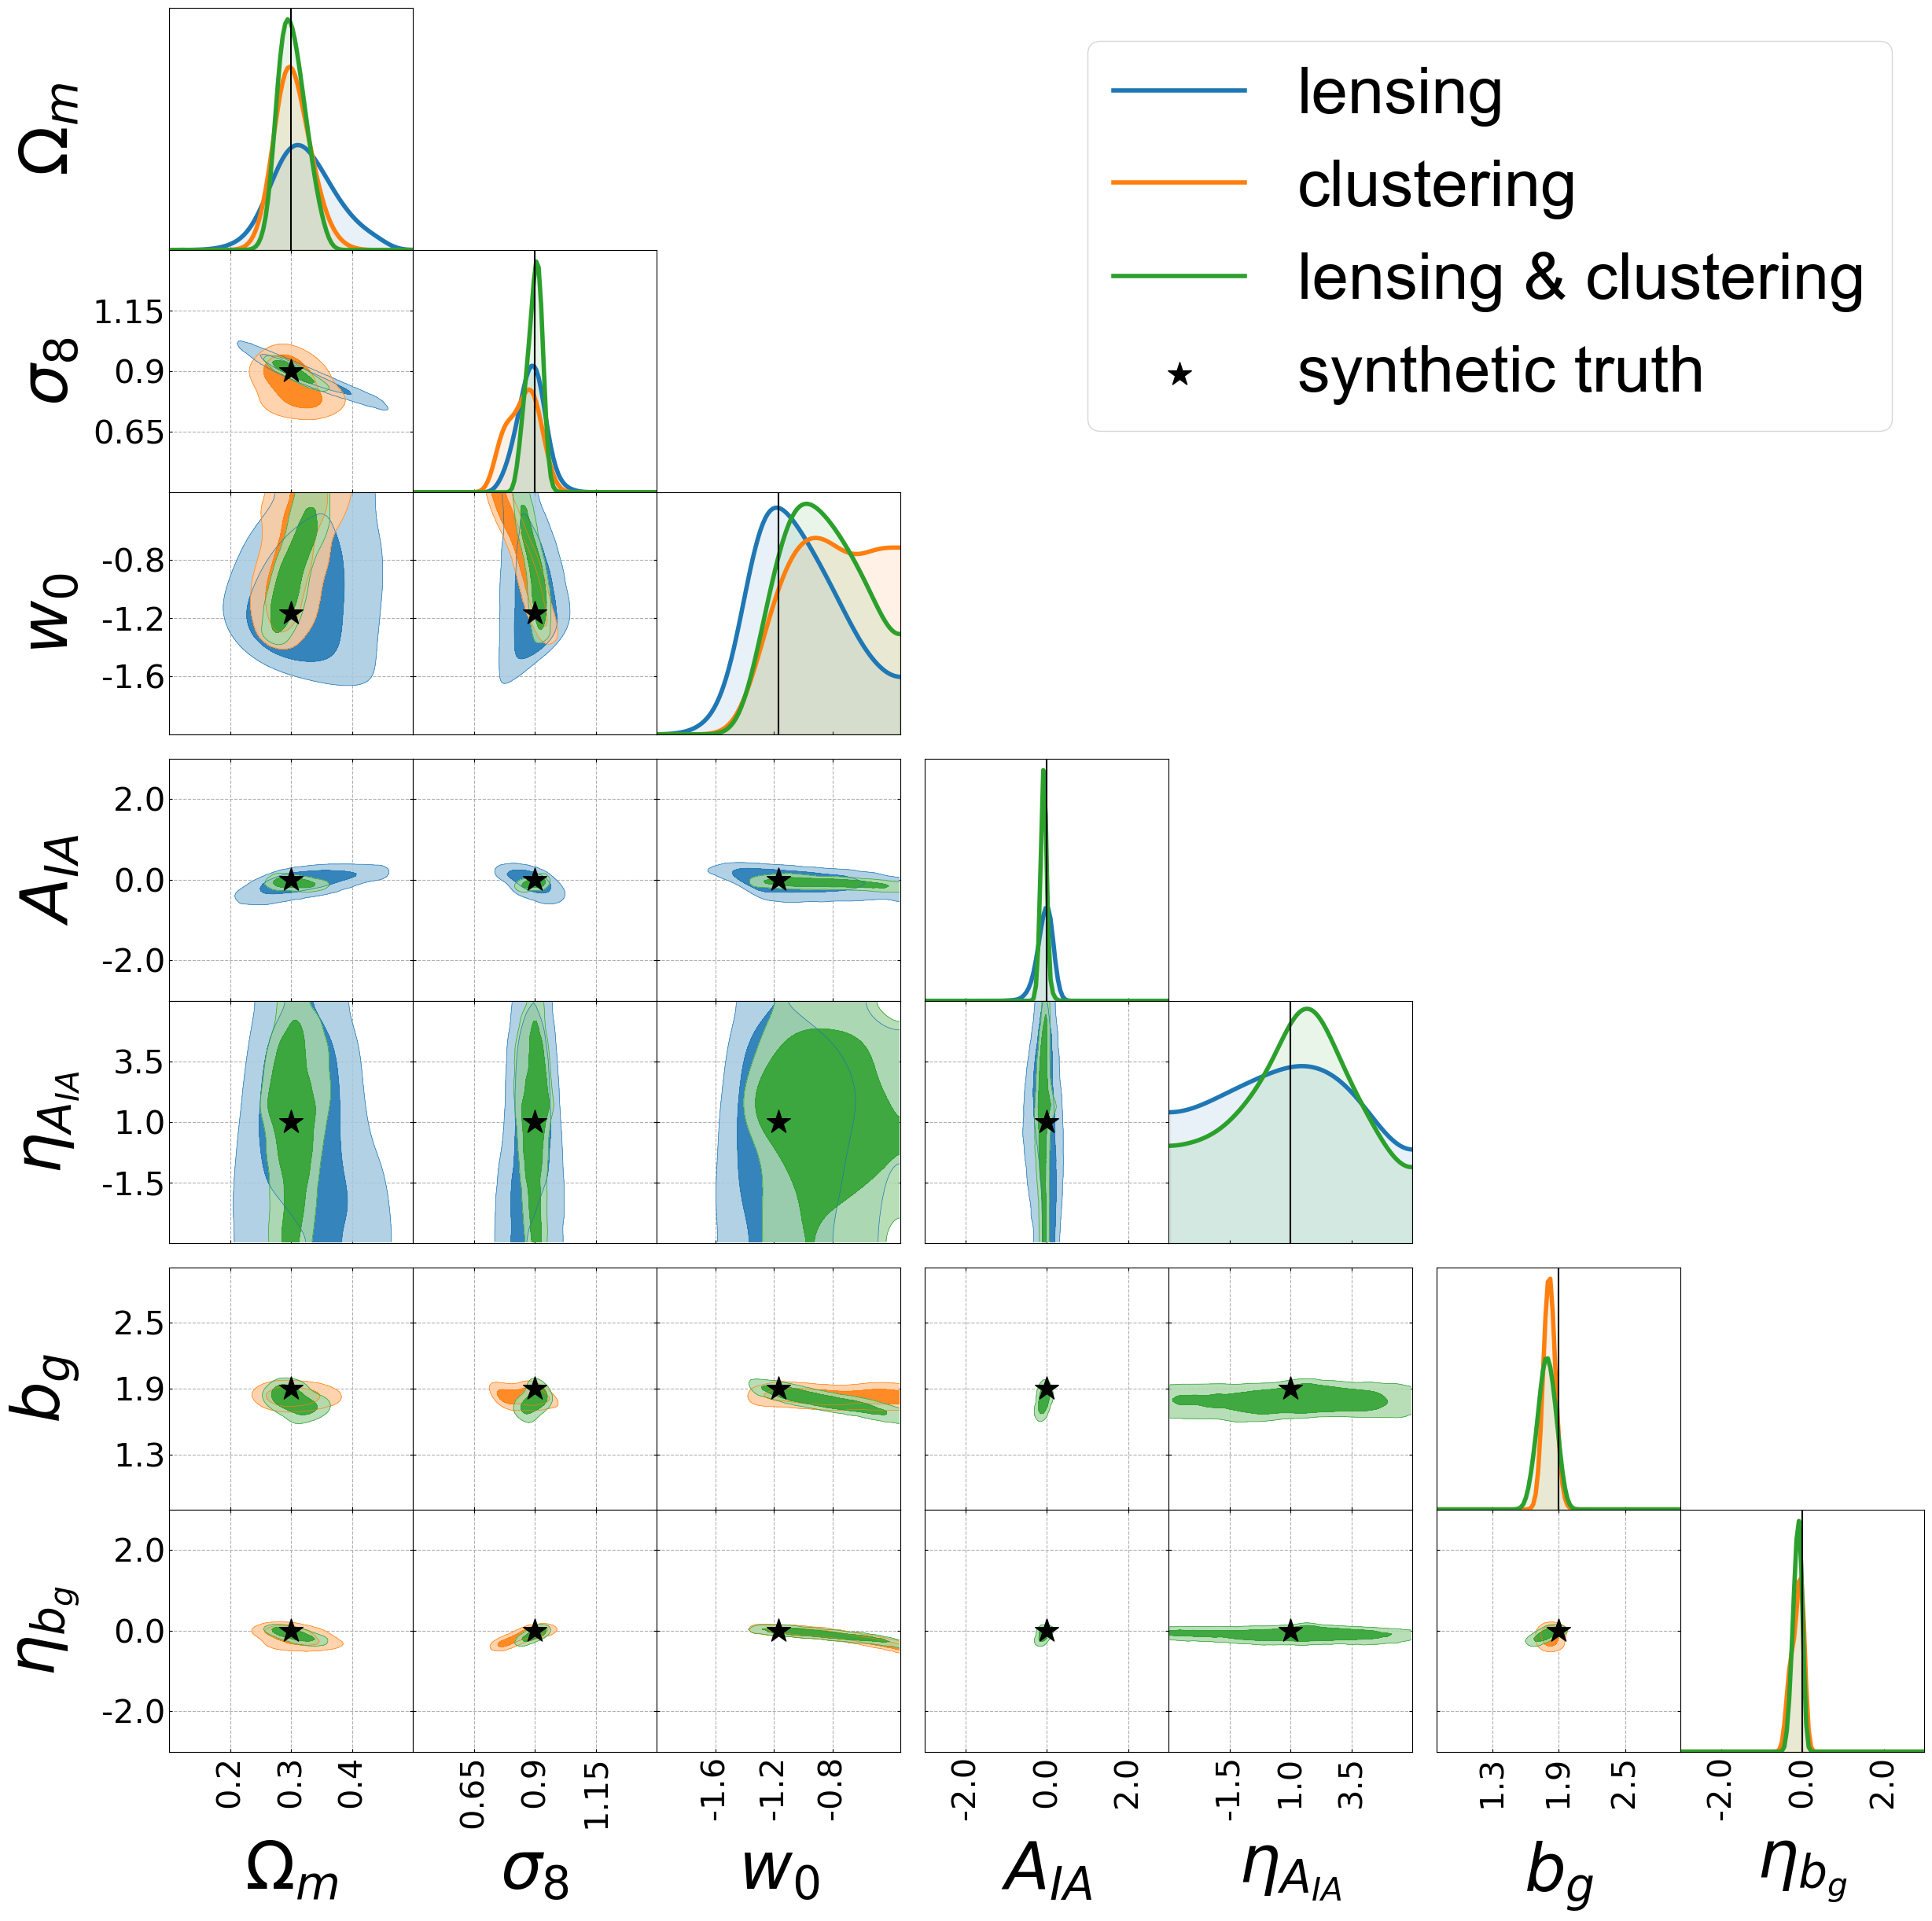

In [25]:
conf = files.load_config("/Users/arne/git/multiprobe-simulation-forward-model/configs/v6/linear_bias.yaml")

density_estimation_method = "likelihood_flow"

chains = []
params = []
labels = []

label = f"_grid_1"

# lensing 
chains.append(np.load(f"/Users/arne/data/DESY3/models/v8/lensing/delta/2024-04-26_05-50-54_resnet_vanilla/100000_steps/likelihood_flow/chain{label}.npy"))
params.append(["Om", "s8", "w0", "Aia", "n_Aia"])
labels.append("lensing")

# clustering
chains.append(np.load(f"/Users/arne/data/DESY3/models/v8/clustering/delta/2024-04-26_05-50-43_resnet_vanilla/80000_steps/likelihood_flow/chain{label}.npy"))
params.append(["Om", "s8", "w0", "bg", "n_bg"])
labels.append("clustering")

# combined
chains.append(np.load(f"/Users/arne/data/DESY3/models/v8/combined/delta/2024-04-26_17-18-07_resnet_vanilla/50000_steps/likelihood_flow/chain{label}.npy"))
params.append(["Om", "s8", "w0", "Aia", "n_Aia", "bg", "n_bg"])
labels.append("lensing & clustering")

tri = plotting.plot_chains(
    chains=chains,
    params=params,
    conf=conf,
    # output
    out_dir="./plots",
    file_label="probe_comparison",
    # cosmetics
    plot_labels=labels,
    fiducial_point={'Om': 0.3, 's8': 0.9, 'w0': -1.1665, 'Aia': 0.0, 'n_Aia': 1.0, 'bg': 1.9, 'n_bg': 0.0},
    plot_fiducial=True,
    group_params=True,
    # cosmo
    with_des_chain=False,
    tri_kwargs={
        "size": 4,
        "label_fontsize": 60,
        "labels_kwargs": {"fontsize": 60},
        "grid_kwargs": {"fontsize_ticklabels": 30},
    }
)

tri.ax.annotate('Your Text', xy=(0.5, 0.5), xycoords='axes fraction', rotation=315, ha='center', va='center')